In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [59]:
from assignment_hw2_module import calc_correlation
from assignment_hw2_module import create_player_question_table
from assignment_hw2_module import create_player_question_table_for_validation
from assignment_hw2_module import plot_scores

In [37]:
from assignment_hw2_module import get_scores

In [3]:
players_file = open(r'data/players.pkl', 'rb')
players = pickle.load(players_file)

In [4]:
results_file = open(r'data/results.pkl', 'rb')
results = pickle.load(results_file)

In [5]:
tournaments_file = open(r'data/tournaments.pkl', 'rb')
tournaments = pickle.load(tournaments_file)

In [6]:
len(tournaments), len(results), len(players)

(5528, 5528, 204063)

1. Разбиваем на трейн и тест. Также оставляем только турниры следующих типов: 'Обычный', 'Синхрон', 'Строго синхронный'. Они входят по правилам в определение рейтинга, покрывают большую часть турниров и с ними меньше проблем при процессинге. Например, турниры "Общий зачет" могут иметь повторяющиеся вопросы и имея один и тот же норм менять длину маски ответов.

In [7]:
tournament_type_to_keep = ['Обычный', 'Синхрон', 'Строго синхронный']

In [8]:
tournament_type = set()

cnt = 0
for key, elem in tournaments.items():
    try:
        t = elem['type']['name']
        tournament_type.add(t)
        if t in tournament_type_to_keep:
            cnt += 1
    except KeyError:
        continue
cnt / len(tournaments)  # доля от всех турниров

0.9129884225759769

In [9]:
train_ids = [elem['id'] for key, elem in tournaments.items() if elem['dateStart'][:4] == '2019' \
             and elem['type']['name'] in tournament_type_to_keep]
test_ids = [elem['id'] for key, elem in tournaments.items() if elem['dateStart'][:4] == '2020'
             and elem['type']['name'] in tournament_type_to_keep]

Получили маску из турниров в 2019 и 2020 годах. Теперь из results достанем списки команд, участников и маски ответов. Глобальная цель: составить пары игрок-вопрос, а также  правильно ли сделан ответ. Используя one-hot-encoding для игроков и для вопросов, получим матрицу признаков, вектор с фактом правильности ответа используем в качестве таргета. На данном этапе будем считать, что правильный ответ команды соответствует правильности ответа данного каждым игроком. 
К этим данным можно применить логистическую регрессию.


In [10]:
teams_dct = {}
train_dct = {}
test_dct = {}

for i, ids in enumerate(train_ids):
    tournaments_dct = {}
    for team in results[ids]:
        cur_mask = team.get('mask')
        if cur_mask is None or not team['teamMembers']:  # нет членов команды или записи ответов
            continue
        cur_mask = cur_mask.replace('?', '0')  # для простоты, заменим на 0 все неопределенности типа X и ?
        cur_mask = cur_mask.replace('X', '0')
        cur_mask = [int(ans) for ans in cur_mask]
        team_id = team['team']['id']
        members = [member['player']['id'] for member in team['teamMembers']]
        tournaments_dct[team_id] = {}
        tournaments_dct[team_id]['team_id'] = team_id
        tournaments_dct[team_id]['mask'] = cur_mask
        tournaments_dct[team_id]['players'] = members
    if len(set(list(map(len, [team['mask'] for team in tournaments_dct.values()])))) == 1:  
        train_dct[ids] = tournaments_dct
        
for i, ids in enumerate(test_ids):
    tournaments_dct = {}
    for team in results[ids]:
        cur_mask = team.get('mask')
        if cur_mask is None or not team['teamMembers']:  # нет членов команды или записи ответов
            continue
        cur_mask = cur_mask.replace('?', '0')  # для простоты, заменим на 0 все неопределенности типа X и ?
        cur_mask = cur_mask.replace('X', '0')
        cur_mask = [int(ans) for ans in cur_mask]
        team_id = team['team']['id']
        members = [member['player']['id'] for member in team['teamMembers']]
        tournaments_dct[team_id] = {}
        tournaments_dct[team_id]['team_id'] = team_id
        tournaments_dct[team_id]['mask'] = cur_mask
        tournaments_dct[team_id]['players'] = members
    if len(set(list(map(len, [team['mask'] for team in tournaments_dct.values()])))) == 1:  
        test_dct[ids] = tournaments_dct
    
        

In [11]:
test_dct.keys()

dict_keys([4957, 5414, 5719, 5730, 5731, 5732, 5746, 5753, 5754, 5787, 5793, 5798, 5799, 5804, 5806, 5809, 5810, 5823, 5846, 5848, 5849, 5856, 5889, 5891, 5923, 5925, 5962, 5968, 5970, 5973, 6002, 6004, 6016, 6019, 6020, 6041, 6042, 6045, 6046, 6059, 6064, 6067, 6070, 6073, 6075, 6076, 6083, 6093, 6095, 6096, 6108, 6109, 6111, 6121, 6124, 6132, 6133, 6134, 6139, 6142, 6160, 6162, 6163, 6165, 6166, 6171, 6176, 6177, 6180, 6181, 6182, 6184, 6185, 6186, 6187, 6188, 6190, 6193, 6196, 6197, 6199, 6200, 6201, 6202, 6204, 6205, 6207, 6208, 6211, 6212, 6213, 6215, 6216, 6217, 6218, 6220, 6221, 6222, 6223, 6225, 6227, 6228, 6229, 6230, 6233, 6234, 6237, 6239, 6244, 6245, 6246, 6247, 6250, 6256, 6257, 6259, 6261, 6262, 6263, 6269, 6270, 6271, 6272, 6277, 6284, 6285, 6289, 6292, 6293, 6295, 6296, 6298, 6301, 6313, 6314, 6317, 6320, 6323, 6325, 6330, 6331, 6339, 6340, 6342, 6405, 6409, 6410, 6428, 6437, 6438, 6456])

In [12]:
train = create_player_question_table(train_dct)  # здесь dataframe собираем с парами

In [13]:
# оставим в тесте только тех, кто в треине был
test_base = create_player_question_table(test_dct) 
test_base = test_base[test_base['player_id'].isin(set(train['player_id']))] 

In [14]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train = encoder.fit_transform(train[['player_id', 'question_id']])
y_train = train['answer']

In [15]:
X_train.shape, y_train.shape

((14583666, 73350), (14583666,))

In [16]:
model_base = LogisticRegression(C=1, random_state=42, max_iter=500, n_jobs=-1)

model_base.fit(X_train, y_train)

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, max_iter=500, n_jobs=-1, random_state=42)

In [17]:
X_test = encoder.transform(test_base[['player_id', 'question_id']])
y_test = test_base['answer']

In [18]:
X_test.shape, y_test.shape

((3217971, 73350), (3217971,))

In [19]:
model_base.score(X_test, y_test)

0.5427034612804155

In [20]:
model_base.coef_

array([[ 0.4799294 ,  1.3371425 ,  0.90541589, ...,  3.00241679,
        -0.57982532,  0.17785832]])

Для валидации посмотрим вероятность того, что хотя бы один член команды сможет ответить на вопрос. В тест добавим еще общее количество правильных ответов у команды

In [21]:
# %load_ext autoreload  # нужно для обновления изменений в модуле.
# %autoreload 2
test_valid = create_player_question_table_for_validation(test_dct, train_ids) 

In [22]:
X_test = test_valid[['player_id', 'question_id']]
X_test = encoder.transform(X_test)
preds = model_base.predict_proba(X_test)[:, 1]

In [23]:
test_valid['pred'] = preds
test_valid['score'] = test_valid.groupby(['tournament_id', 'team_id'])['pred'].transform(lambda x: 1 - np.prod(1 - x))
rating = test_valid[['tournament_id', 'team_id', 'points', 'score']].drop_duplicates().reset_index(drop=True)
rating = rating.sort_values(by=['tournament_id', 'points'], ascending=False)
rating['real_rank'] = rating.groupby('tournament_id')['points'].transform(lambda x: np.arange(1, len(x) + 1))
rating = rating.sort_values(by=['tournament_id', 'score'], ascending=False)
rating['pred_rank'] = rating.groupby('tournament_id')['score'].transform(lambda x: np.arange(1, len(x) + 1))
rating = rating.astype(np.int32)

In [24]:
calc_correlation(rating, typ='spearman'), calc_correlation(rating, typ='kendalltau')

(0.6052112780836185, 0.5555728029445176)

Получили относительно неплохое значение корреляции с истинными значениями турниров

EM-алгоритм.
Введем скрытую переменную $z_{ij}$ - ответил ли iй игрок на jй вопрос. Соответственно $y_{kj}$ - ответила ли k-я команда на j-й вопрос. На шаге Е, будем определять и обновлять следующую величину:
$E[z_{ij}] = P[ответил \, игрок| команда \, ответила]$


In [27]:
train = create_player_question_table(train_dct)

In [28]:
model_for_m_step = LogisticRegression(C=1, random_state=42, n_jobs=-1, max_iter=10)

In [55]:
from em import EMClassifier

In [47]:
em_classifier = EMClassifier(model_base)

In [48]:
em_classifier.fit(X_train, train, X_test, test_valid)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49


In [51]:
spearman = [elem[0] for elem in em_classifier.scores]
kendalltau = [elem[1] for elem in em_classifier.scores]
iters = [i+1 for i in range(len(em_classifier.scores))]

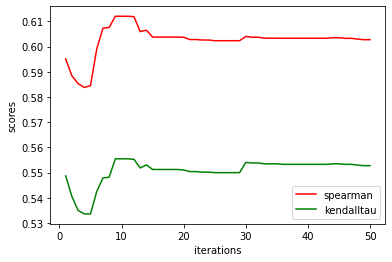

In [54]:
plt.plot(iters, spearman, color='r', label='spearman')
plt.plot(iters, kendalltau, color='g', label='kendalltau')

plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("")
plt.legend()
plt.show()

В начале наблюдается ожидаемый рост характеристик, затем падение. Возможно из-за переобучения. Обучим модель заново, оставив только 10 итераций.

In [56]:
updated_em = EMClassifier(model_base)

In [57]:
updated_em.fit(X_train, train, X_test, test_valid)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9


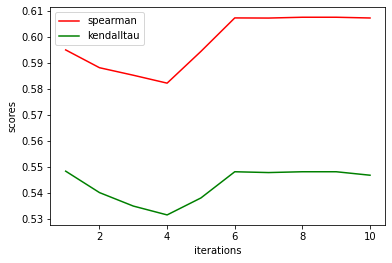

In [61]:
plot_scores(updated_em.scores)

Построим повопросный рейтинг

In [68]:
q_rating = dict(zip(np.unique(train['question_id']), updated_em.w[-len(np.unique(train['question_id'])):]))
train['difficulty'] = train['question_id'].map(q_rating)
train['tournament_name'] = train['tournament_id'].map({v['id']: v['name']for k, v in tournaments.items()})

In [69]:
tournaments_rating = train[['tournament_name', 'question_id', 'difficulty']].drop_duplicates()
tournaments_rating = tournaments_rating.groupby('tournament_name')['difficulty'].mean().sort_values().reset_index()

In [70]:
tournaments_rating.head(30)  

,tournament_name,difficulty
0,Чемпионат Санкт-Петербурга. Первая лига,-4.571918
1,Угрюмый Ёрш,-2.026828
2,Синхрон высшей лиги Москвы,-1.887739
3,Первенство правого полушария,-1.823139
4,Воображаемый музей,-1.697624
5,Кубок городов,-1.601698
6,Записки охотника,-1.506810
7,Чемпионат России,-1.485010
8,Ускользающая сова,-1.455377
9,Чемпионат Мира. Этап 3. Группа В,-1.417181


Самые сложные турниры. В топ 30 есть турниры есть сложные турниры, если судит по названию. Например, чемпионаты России и мира.